Free diffusion

In [715]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [716]:
# Physical parameters
T_K = 300
k_b = 1.3806452e-23
R_m = 1e-6
m_kg = 1.1e-14 
viscosity_NS_m2 = 0.001
load = 6*np.pi*viscosity_NS_m2*R_m 
tau = m_kg/load
einstein_diffusion = k_b*T_K/load
dt_s = 100*tau
print("einstein_diffusion coefficient",einstein_diffusion)

einstein_diffusion coefficient 2.197365082360985e-13


In [717]:
# Generating the random sequence

def generate_seq(N):
    standard_deviation = 1 
    W_seq = np.array(np.random.normal(0,standard_deviation,N))
    return W_seq

def walk_free_diffusion(N):
    w = generate_seq(N)
    x = np.zeros(N)
    for i in range(1,N):
        x[i] = x[i-1] + np.sqrt(2*einstein_diffusion*dt_s)*w[i]
    return x

In [718]:
def mean_square_displacement(array):
    msd = []
    centered_array = array - np.mean(array)
    for j in range(1,int(len(centered_array))):
        M = np.mean((centered_array[:-j] - centered_array[j:])**2)
        msd.append(M)
    return np.array(msd)

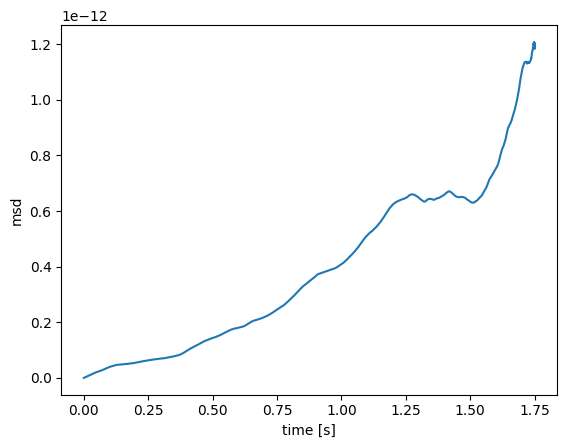

In [719]:
N = 30000
traj_free = walk_free_diffusion(N)
msd_free = mean_square_displacement(traj_free)
t = np.arange(len(msd_free))*dt_s
plt.plot(t,msd_free)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.show()

Generating W trajectories and computing the respective msd in ordrer to have a mean msd array

In [720]:
def msd_W_trajs(W,N):
    msd_list = []
    mean_msd = np.zeros(N-1)
    for j in range(W):
        traj = walk_free_diffusion(N)
        msd_list.append(mean_square_displacement(traj))
    for msd in msd_list:
        mean_msd = np.add(mean_msd,msd)
    mean_msd *= 1/W
    return mean_msd

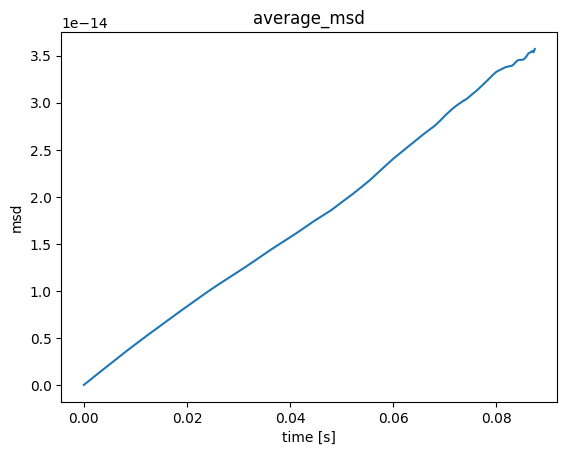

In [721]:
mean_msd = msd_W_trajs(100,1500)
t = np.arange(len(mean_msd))*dt_s
plt.plot(t,mean_msd)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.title('average_msd')
plt.show()

R-squared: 0.996904082905921
Error Range (95% CI): 2.0033878917334557e-13 to 2.0111068799939952e-13
diffusion_coefficient 2.0072473858637255e-13 einstein_diffusion 2.197365082360985e-13


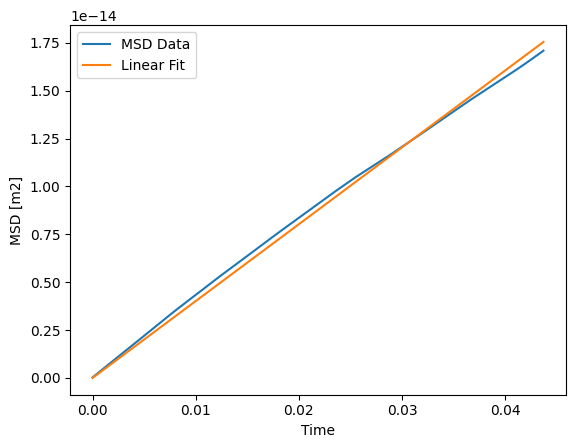

In [722]:
# Fiting the msd

def linear_fit(t, D):
    return 2 * D * t

# Reducing the array for a better fit
mean_msd = mean_msd[0:-int(len(mean_msd)/2)]
t = t[0:-int(len(t)/2)]

initial_guess = einstein_diffusion

# Perform the fit
params, covariance = curve_fit(linear_fit, t, mean_msd, p0=initial_guess)

# Extract the diffusion coefficient
diffusion_coefficient = params[0]

#Confidence interval:
residuals = mean_msd - linear_fit(t, diffusion_coefficient)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_msd - np.mean(mean_msd))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

std_errors = np.sqrt(np.diag(covariance))
confidence_interval = 1.96 * std_errors  # for 95% confidence interval

print("Error Range (95% CI):", diffusion_coefficient - confidence_interval[0], "to", diffusion_coefficient + confidence_interval[0])
print("diffusion_coefficient",diffusion_coefficient,"einstein_diffusion",einstein_diffusion)
plt.plot(t, mean_msd, label='MSD Data')
plt.plot(t, linear_fit(t , diffusion_coefficient), label='Linear Fit')
plt.xlabel('Time')
plt.ylabel('MSD [m2]')
plt.legend()
plt.show()

Determination of diffusion coefficient in periodic potential

In [723]:
# Additionnal physical parameters:
space_step = 1e-14
amplitude_J = 100*k_b*T_K
frequency_hz = 10e8

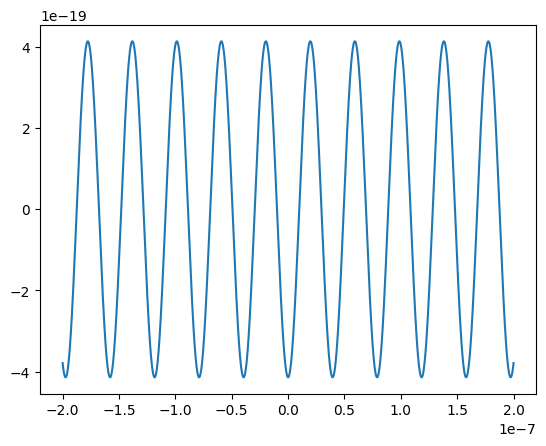

In [724]:
def periodic_potential(A,x):
    return -A*np.cos(x*frequency_hz/(2*np.pi))
X = np.linspace(-200*1e-9,200*1e-9,4000)
plt.plot(X,periodic_potential(amplitude_J,X))
plt.show()

In [725]:
def static_process(N,A):
    x = 0
    stored_position = []
    w = generate_seq(N)
    for i in np.arange(0,N):
        dx = -(1/load)*dt_s*(periodic_potential(A,x+space_step) - periodic_potential(A,x))/space_step
        dx = dx + np.sqrt(2*einstein_diffusion*dt_s)*w[i]
        x = x + dx
        stored_position.append(x)
        dx = 0
    return stored_position

In [726]:
def msd_U_trajs(W,N):
    msd_list = []
    mean_msd = np.zeros(N-1)
    for j in range(W):
        traj = static_process(N,amplitude_J)
        msd_list.append(mean_square_displacement(traj))
    for msd in msd_list:
        mean_msd = np.add(mean_msd,msd)
    mean_msd *= 1/W
    median_position= traj[int(len(traj)/2)]
    return mean_msd,median_position

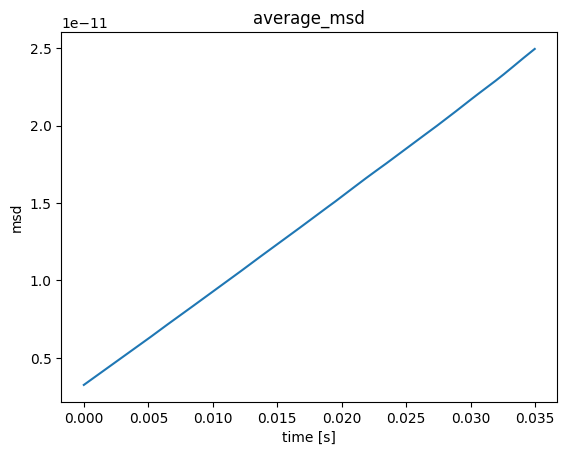

In [727]:
mean_msd,median_position = msd_U_trajs(100,1500)
mean_msd = mean_msd[100:700]
t = np.arange(len(mean_msd))*dt_s
plt.plot(t,mean_msd)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.title('average_msd')
plt.show()

R-squared: 0.9372658127517608
Error Range (95% CI): 3.729093558107876e-10 to 3.791166487659648e-10
periodic_diffusion_coefficient 3.760130022883762e-10 einstein_diffusion 2.197365082360985e-13


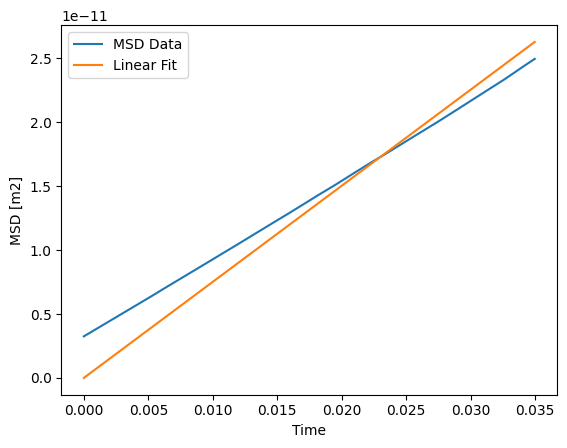

In [728]:
def linear_fit(t, D):
    return 2 * D * t

initial_guess = einstein_diffusion/1.2
# Reducing the array for a better fit

# Perform the fit
params, covariance = curve_fit(linear_fit, t, mean_msd, p0=initial_guess)

# Extract the diffusion coefficient
diffusion_coefficient = params[0]

#Confidence interval:
residuals = mean_msd - linear_fit(t, diffusion_coefficient)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_msd - np.mean(mean_msd))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

std_errors = np.sqrt(np.diag(covariance))
confidence_interval = 1.96 * std_errors  # for 95% confidence interval

print("Error Range (95% CI):", diffusion_coefficient - confidence_interval[0], "to", diffusion_coefficient + confidence_interval[0])
print("periodic_diffusion_coefficient",diffusion_coefficient,"einstein_diffusion",einstein_diffusion)
plt.plot(t, mean_msd, label='MSD Data')
plt.plot(t, linear_fit(t , diffusion_coefficient), label='Linear Fit')
plt.xlabel('Time')
plt.ylabel('MSD [m2]')
plt.legend()
plt.show()

Computing expected diffusion from Lifson and jackson equation:
$$D = \frac{D_0}{I_0²(d_0/k_bT)}$$
with $I_0 = exp(x)/\sqrt{2*\pi*x}$
But as our wave lenght is different from 1 we must use :

In [729]:
import scipy.integrate as integrate
X = np.linspace(0,median_position,10000)
def fmin(x):
    return np.exp(-periodic_potential(amplitude_J,x)/(k_b*T_K))
I0min, _ =  integrate.quad(fmin, 0, median_position)
I0min = (1/frequency_hz)*I0min
print(I0min)


-4.1565844894433315e+27


/tmp/ipykernel_13250/2288414285.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I0min, _ =  integrate.quad(fmin, 0, median_position)


In [730]:


def fplus(x):
    return np.exp(periodic_potential(amplitude_J,x)/(k_b*T_K))
I0plus, _ =  integrate.quad(fplus, 0, median_position)
I0plus = (1/frequency_hz)*I0plus


corrected_D = (I0min*I0plus)*diffusion_coefficient
print("corrected_diffusion_coefficient",corrected_D,"einstein_diffusion",einstein_diffusion)
print(median_position,np.cos(median_position))

corrected_diffusion_coefficient 9.598354924213902e+45 einstein_diffusion 2.197365082360985e-13
-8.350642053116166e-06 0.9999999999651333


/tmp/ipykernel_13250/3529775335.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I0plus, _ =  integrate.quad(fplus, 0, median_position)
